# Titanic - Feature Engineering Name Miner

In [1]:
# import necessary library
from os.path import join
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# load feature engineered dataset (FamilySize)
path_dir = join("..", "..", "data")
input_dir = join(path_dir, "preprocessed")
output_dir = join(path_dir, "feature_engineered", "nameMiner")
df = pd.read_csv(join(input_dir, "preprocessed_train.csv"))
df_test = pd.read_csv(join(input_dir, "preprocessed_test.csv"))

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2


In this feature engineering, we'll try to explore the `Name` feature because this can hint about a passenger’s social status, gender, and family relationships. For example, the Name column contains titles such as Mr., Mrs., Miss., Master., or Dr., which often correlate with factors like age, gender, and survival probability. By extracting and grouping these titles, we can create new, more meaningful features that may improve the model’s predictive performance.

In [2]:
import re 
# Tách danh xưng (Title) từ Name
def extract_title(name: str) -> str:
    """
    Extract the title (Mr, Mrs, Miss, etc.) from a passenger's name.
    Example: 'Braund, Mr. Owen Harris' -> 'Mr'
    """
    match = re.search(r',\s*([^\.]+)\.', name)
    return match.group(1).strip() if match else "Unknown"


#  Tách họ (Surname) từ Name
def extract_surname(name: str) -> str:
    """
    Extract the surname (family name) from a passenger's name.
    Example: 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)' -> 'Cumings'
    """
    return name.split(',')[0].strip() if isinstance(name, str) else "Unknown"


# --- Tạo các feature cơ bản từ Name ---
def create_name_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Extract cơ bản
    df['Title'] = df['Name'].apply(extract_title)
    df['Surname'] = df['Name'].apply(extract_surname)
    df['Name_Length'] = df['Name'].apply(lambda s: len(s) if isinstance(s, str) else 0)
    df['Name_WordCount'] = df['Name'].apply(lambda s: len(s.split()) if isinstance(s, str) else 0)
    df['Has_Parentheses'] = df['Name'].apply(lambda s: int('(' in s) if isinstance(s, str) else 0)

    # Chuẩn hóa danh xưng
    title_map = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Rare', 'Countess': 'Rare', 'Sir': 'Rare',
        'Don': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare',
        'Rev': 'Clergy', 'Dr': 'Officer', 'Major': 'Officer',
        'Col': 'Officer', 'Capt': 'Officer'
    }
    df['Title'] = df['Title'].replace(title_map)

    # ✅ Gom nhóm Officer vào Rare để khỏi sinh cột riêng
    df['Title_Group'] = df['Title'].apply(
        lambda t: t if t in ['Mr', 'Mrs', 'Miss', 'Master', 'Clergy'] else 'Rare'
    )

    return df


#  Tạo các feature về gia đình
def create_family_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if 'Surname' not in df.columns:
        df['Surname'] = df['Name'].apply(extract_surname)

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilyID'] = df['Surname'] + '_' + df['FamilySize'].astype(str)

    # ✅ Gom nhóm FamilyID_Mod lại để không tạo thêm cột
    df['FamilyID_Mod'] = df['FamilySize'].apply(lambda x: 'Small' if x <= 3 else 'Large')

    # Nếu test không có nhóm nào, gom hết về Small cho an toàn
    df['FamilyID_Mod'] = df['FamilyID_Mod'].apply(lambda x: x if x in ['Small', 'Large'] else 'Small')

    return df


Four function above can help we handle the feature `Name` and now we'll implement this for our dataframe

In [3]:
df = create_name_features(df)
df = create_family_features(df)
df_test = create_name_features(df_test)
df_test = create_family_features(df_test)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Surname,Name_Length,Name_WordCount,Has_Parentheses,Title_Group,FamilySize,FamilyID,FamilyID_Mod
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,Mr,Braund,23,4,0,Mr,2,Braund_2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,Mrs,Cumings,51,7,1,Mrs,2,Cumings_2,Small
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,Miss,Heikkinen,22,3,0,Miss,1,Heikkinen_1,Small
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,Mrs,Futrelle,44,7,1,Mrs,2,Futrelle_2,Small
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,Mr,Allen,24,4,0,Mr,1,Allen_1,Small


Let's encode those feature we just got with this function

In [4]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode categorical string features into numeric values for training.
    - If feature has low cardinality -> One-hot encoding
    - Otherwise -> Label encoding
    """
    df = df.copy()
    label_encoder = LabelEncoder()

    for col in df.select_dtypes(include=['object']).columns:
        n_unique = df[col].nunique()

        # Nếu ít giá trị duy nhất, dùng one-hot
        if n_unique <= 6:
            df = pd.get_dummies(df, columns=[col], prefix=col)
        else:
            # Label encode nếu nhiều giá trị (vd: FamilyID_Mod)
            df[col] = label_encoder.fit_transform(df[col].astype(str))

    return df

Implement our features with function above:

In [5]:
df = encode_categorical_features(df)
df_test = encode_categorical_features(df_test)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,FamilyID,Title_Group_Clergy,Title_Group_Master,Title_Group_Miss,Title_Group_Mr,Title_Group_Mrs,Title_Group_Rare,FamilyID_Mod_Large,FamilyID_Mod_Small
0,1,0,3,108,1,22.0,1,0,523,7.2500,...,2,77,False,False,False,True,False,False,False,True
1,2,1,1,190,0,38.0,1,0,596,71.2833,...,2,143,False,False,False,False,True,False,False,True
2,3,1,3,353,0,26.0,0,0,669,7.9250,...,1,268,False,False,True,False,False,False,False,True
3,4,1,1,272,0,35.0,1,0,49,53.1000,...,2,208,False,False,False,False,True,False,False,True
4,5,0,3,15,1,35.0,0,0,472,8.0500,...,1,11,False,False,False,True,False,False,False,True


Finally we just drop some features useless and export to csv file

In [6]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop unused or redundant columns after feature engineering.
    Typically removes 'Name', 'Ticket', 'Cabin', or any columns you don't need for training.
    """
    df = df.copy()
    drop_cols = [col for col in ['Name', 'SibSp', 'Parch'] if col in df.columns]
    df.drop(columns=drop_cols, inplace=True)
    return df

df = drop_unused_features(df)
df_test = drop_unused_features(df_test)

df.to_csv(join(output_dir,"nameMiner_engineered_train.csv"))
df_test.to_csv(join(output_dir,"nameMiner_engineered_test.csv"))

correlation

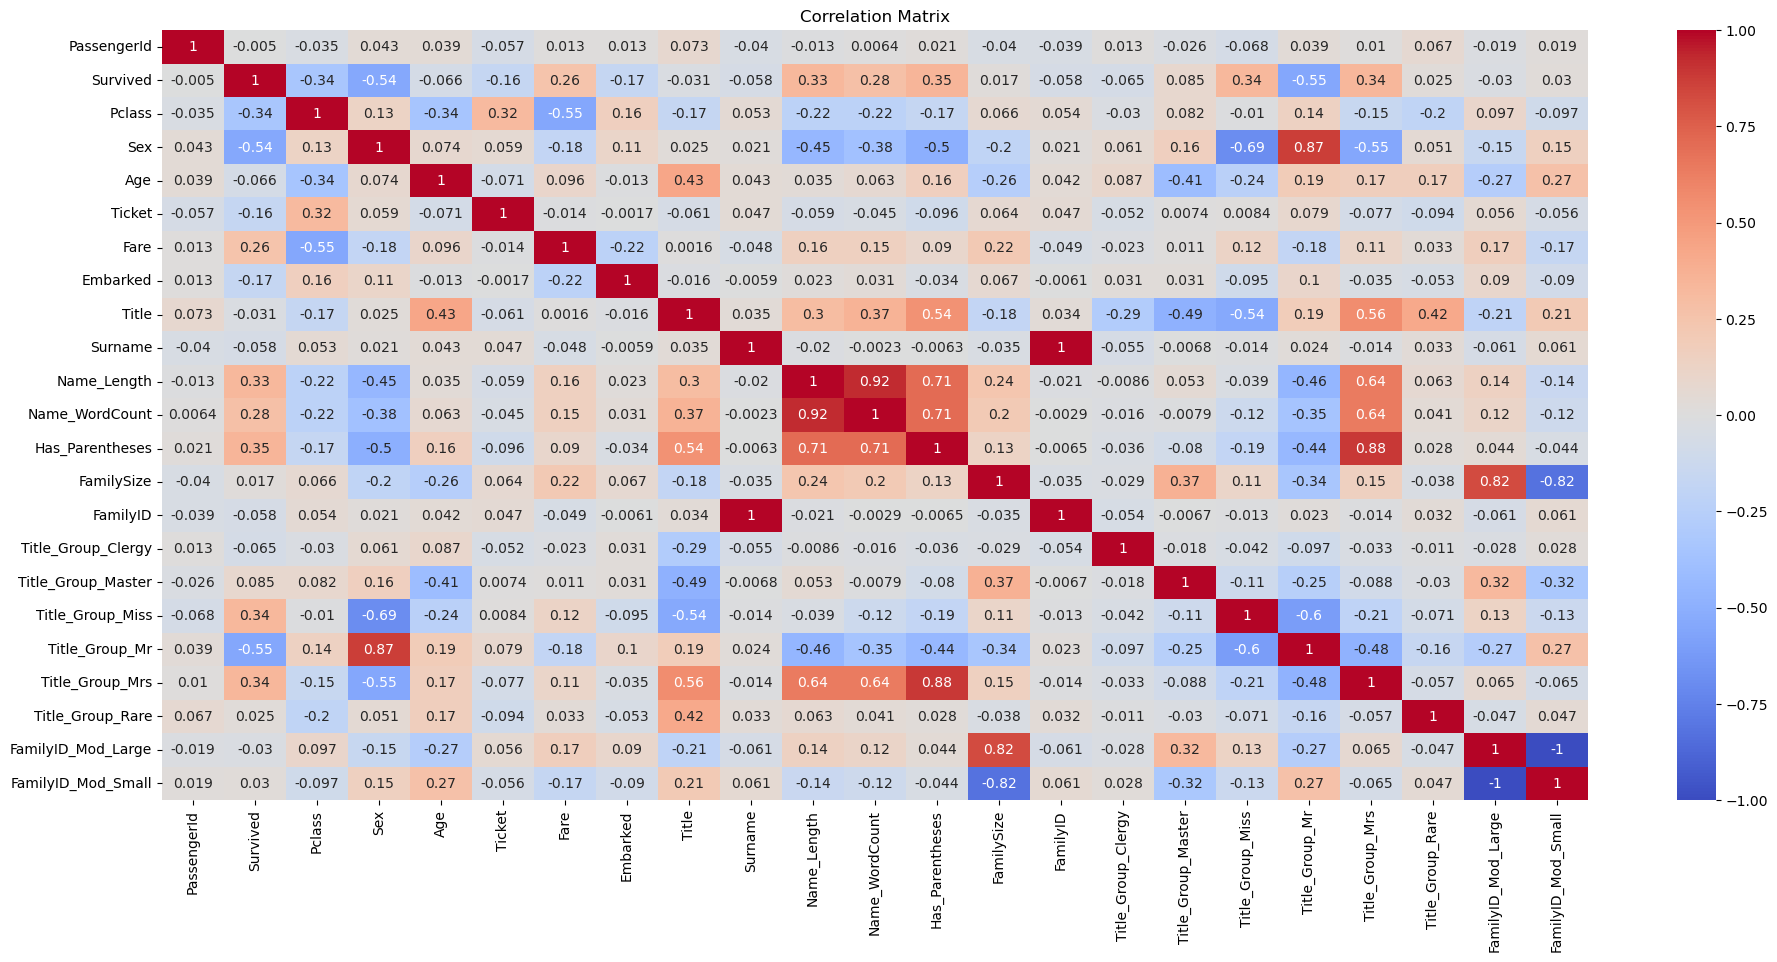

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(23,10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
plt.figure(figsize=(23,10))
sns.heatmap(df.drop.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()